In [75]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

In [76]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

train_bboxes = get_bboxes(paths['train']['bboxes'])
val_bboxes   = get_bboxes(paths['val']['bboxes'])
test_bboxes  = get_bboxes(paths['test']['bboxes'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

nosat_images = get_images(r'data/nosat/')
max_test_key = max(test_images.keys())
for key in nosat_images:
    test_images[max_test_key + key] = nosat_images[key]
    test_masks[max_test_key + key] = np.zeros(original_dims)
    test_bboxes[max_test_key + key] = None
    
print(f'num test_images: {len(test_images)}')

num train_images: 411
num val_images: 102
num test_images: 101
num test_images: 126


In [77]:
# for idx, image in train_images.items():
#     if idx in train_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/train/images/' + str(idx) + '.png')
        
#         seg_model_size = train_correct_masked_images[idx]
        
#         masks = all_train_masks[seg_model_size][idx]
#         bbox = train_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/train/masks/' + str(idx) + '.png')
        
#         bbox = train_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/train/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [78]:
# for idx, image in val_images.items():
#     if idx in val_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/val/images/' + str(idx) + '.png')
        
#         seg_model_size = val_correct_masked_images[idx]
        
#         masks = all_val_masks[seg_model_size][idx]
#         bbox = val_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/val/masks/' + str(idx) + '.png')
        
#         bbox = val_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/val/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [79]:
# for idx, image in test_images.items():
#     if idx in test_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/test/images/' + str(idx) + '.png')
        
#         seg_model_size = test_correct_masked_images[idx]
        
#         masks = all_test_masks[seg_model_size][idx]
#         bbox = test_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/test/masks/' + str(idx) + '.png')
        
#         bbox = test_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/test/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [80]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset, Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    
    val_img_patches = []
    val_mask_patches = []

    test_img_patches = []
    test_mask_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process val images
    i = 0
    for key in tqdm(val_images):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                val_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = val_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                val_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process test images
    i = 0
    for key in tqdm(test_images):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = test_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    
    X_val = np.array(val_img_patches)
    Y_val = np.array(val_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
    X_val = X_val[valid_indices]
    Y_val = Y_val[valid_indices]
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    val_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
        "mask":  [Image.fromarray(mask) for mask in Y_val],
    }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
    }

    train_dataset = Dataset.from_dict(train_dict)
    val_dataset  = Dataset.from_dict(val_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    
    return train_dataset, val_dataset, test_dataset

In [81]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [82]:
patch_size = 256
# image_size = 512

# train_dataset, val_dataset, test_dataset = prepare_datasets(patch_size, (image_size, image_size))

In [83]:
# train_dataset, val_dataset, test_dataset

In [84]:
# img_num = random.randint(0, n_train-1)
# example_image = train_dataset[img_num]["image"]
# example_mask = np.array(train_dataset[img_num]["mask"]) * 255
# # example_bbox = train_dataset[img_num]["bbox"]

# bbox = get_bounding_box(np.array(example_mask))

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the iamge on left
# axes[0].imshow(np.array(example_image), cmap='gray')
# axes[0].set_title("Image")

# # Plot the mask on right
# axes[1].imshow(example_mask, cmap='gray')
# axes[1].set_title("Mask")

# # Hide axis ticks and labels
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
#     rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
#     # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
#     ax.add_patch(rect_pred)
#     # ax.add_patch(rect_true)

# plt.show()

In [85]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)
        prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [86]:
def load_model_and_processor(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    model.load_state_dict(torch.load(model_path))
    
    return model, processor

def load_model_and_processor2(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, processor

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [87]:
def prepare_image(image: np.ndarray, dims: tuple[int, int], verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.5, verbose=True) -> (torch.Tensor, torch.Tensor):
    start_time = time.time()
    model.eval()
    
    patches = prepare_image(image, dims, verbose=verbose)
    
    prob = None
    
    for row_patches in patches:
        row_prob = None
        for patch in row_patches:
            inputs = processor(patch, return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)
            single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
            # print(single_patch_prob.max())
            # single_patch_prob = single_patch_prob / np.sum(single_patch_prob)
            # print(single_patch_prob.max())
            # print()
            
            if row_prob is None:
                row_prob = single_patch_prob
            else:
                row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
                
        if prob is None:
            prob = row_prob
        else:
            prob = np.concatenate((prob, row_prob), axis=0)
    
    # # Find top 4 patches with highest stddev
    # highest_stddev = []
    # for i in range(int(prob.shape[0] / patch_size)):
    #     for j in range(int(prob.shape[1] / patch_size)):
    #         patch = prob[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    #         stddev = np.std(patch)
    #         highest_stddev.append((i, j, stddev))
    # highest_stddev = sorted(highest_stddev, key=lambda x: x[2], reverse=True)[:4]
    # print([(i, j) for i, j, _ in highest_stddev])
    
    # # Zero patches not in highest_stddev
    # for i in range(int(prob.shape[0] / patch_size)):
    #     for j in range(int(prob.shape[1] / patch_size)):
    #         if (i, j) not in [(i, j) for i, j, _ in highest_stddev]:
    #             prob[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
    
    pred = (prob > prob.max() * thresh).astype(np.uint8)
    
    pred = resize_image(pred, original_dims[1], original_dims[0])
    prob = resize_image(prob, original_dims[1], original_dims[0])
    
    end_time = time.time()
    if verbose:
        print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
    return pred, prob

def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int, bbox: tuple = None) -> None:
    if bbox:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fix, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(idx)

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Prediction")
    
    if bbox:
        axes[3].imshow(prediction, cmap='gray') 
        axes[3].set_title("Prediction with bbox")
        
        (x, y), w, h = bbox
        r = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3].add_patch(r)

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

In [88]:
device = get_device()

models = {}
processors = {}

model_paths = {
    512: "finetuned_sam_checkpoints/512_checkpoints_2/epoch_200.pt",
    5120: "finetuned_sam_checkpoints/512.pth",
    1024: "finetuned_sam_checkpoints/1024.pth",
    2048: "finetuned_sam_checkpoints/2048.pth"
}

for size in model_paths.keys():
    model, processor = load_model_and_processor2(model_paths[size]) if size == 512 else load_model_and_processor(model_paths[size])
    model.to(device)
    models[size] = model
    processors[size] = processor
    
torch.cuda.empty_cache()

finetuned_sam_checkpoints/512_checkpoints_2/epoch_200.pt
finetuned_sam_checkpoints/512.pth
finetuned_sam_checkpoints/1024.pth
finetuned_sam_checkpoints/2048.pth


In [89]:
image_size = 512
model = models[image_size]
processor = processors[image_size]

device = get_device()
model.to(device)

x_factor = original_dims[1] / image_size
y_factor = original_dims[0] / image_size

keys_list = []
for k in test_images.keys():
    keys_list.append(k)

# idx = random.choice(keys_list)
idx = 165
image = test_images[idx]

mask_pred, mask_prob = predict(model, processor, device, image, (image_size, image_size), 0.2)
bbox = test_bboxes[idx]

(x, y), w, h = bbox
bbox = ((round(x/x_factor), round(y/y_factor)), round(w/x_factor), round(h/y_factor))

if mask_within_bbox(mask_pred, bbox):
    print(True)
else:
    print(False)

plot_prediction(image, mask_pred, mask_prob, idx, bbox)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.59 seconds


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

(2, 2, 256, 256, 3)


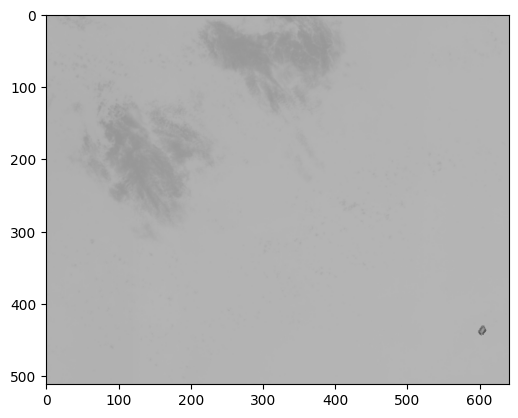

In [91]:
import cv2 as cv

plt.imshow(image)
patches = prepare_image(image, (image_size, image_size), verbose=False)
print(patches.shape)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 1.20 seconds


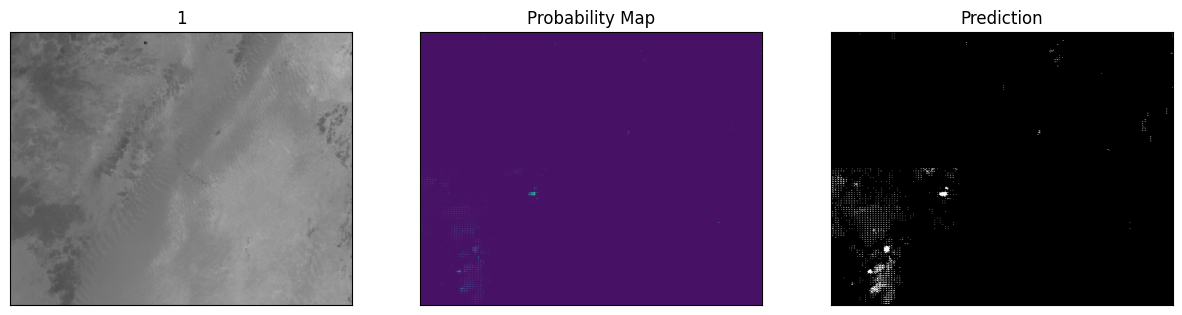

In [ ]:
# keys = list(test_images.keys())
# idx = random.choice(keys)
idx = 1
test_image = train_images[idx]

image_size = 512
model = models[512]
processor = processors[512]

pred, prob = predict(model, processor, device, test_image, (image_size, image_size), thresh=0.01)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.12 seconds


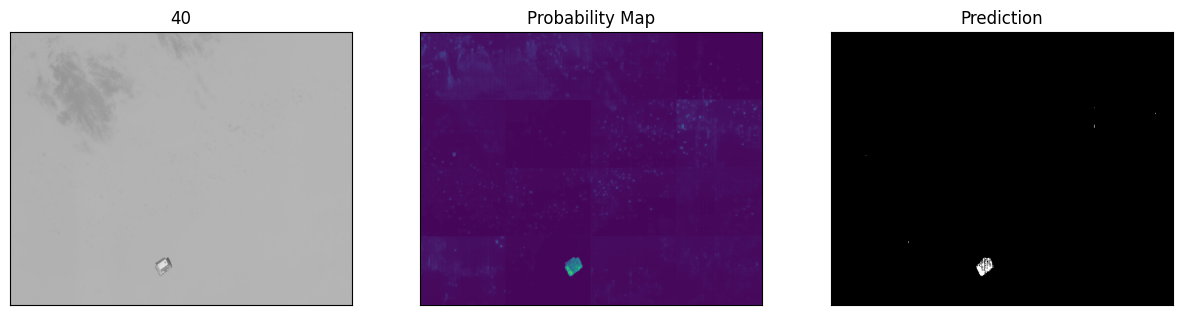

In [ ]:
idx = 40
test_image = test_images[idx]

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.3)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.04 seconds
Time taken to predict: 8.33 seconds


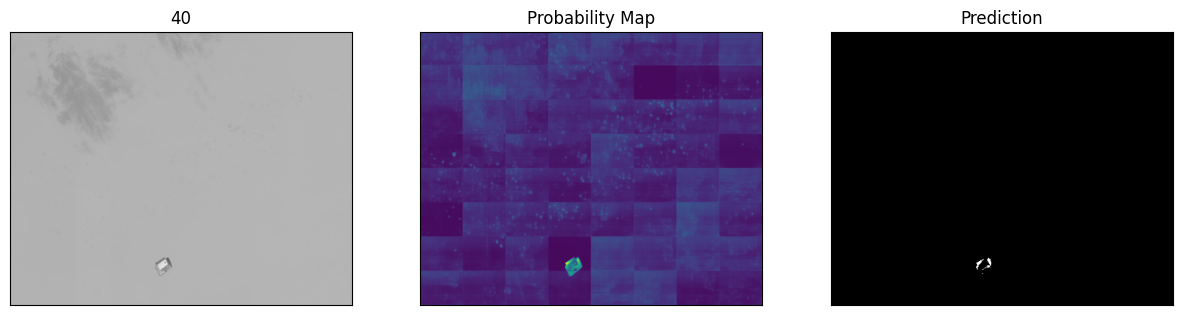

In [ ]:
idx = 40
test_image = test_images[idx]

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.52 seconds


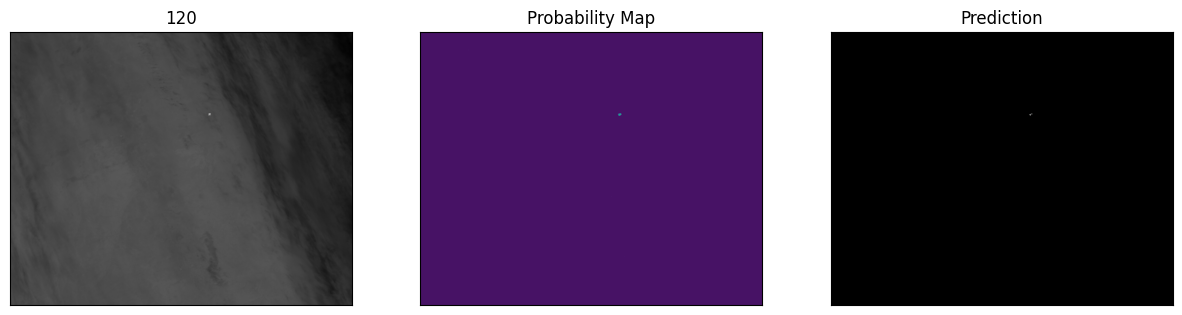

In [ ]:
# idx = random.randint(1, len(test_images))
idx = 120
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.08 seconds


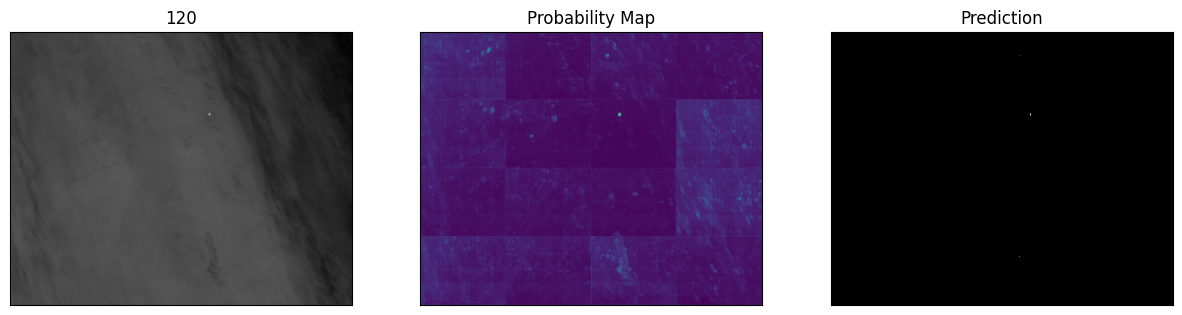

In [ ]:
idx = 120
test_image = test_images[idx]

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.03 seconds
Time taken to predict: 8.28 seconds


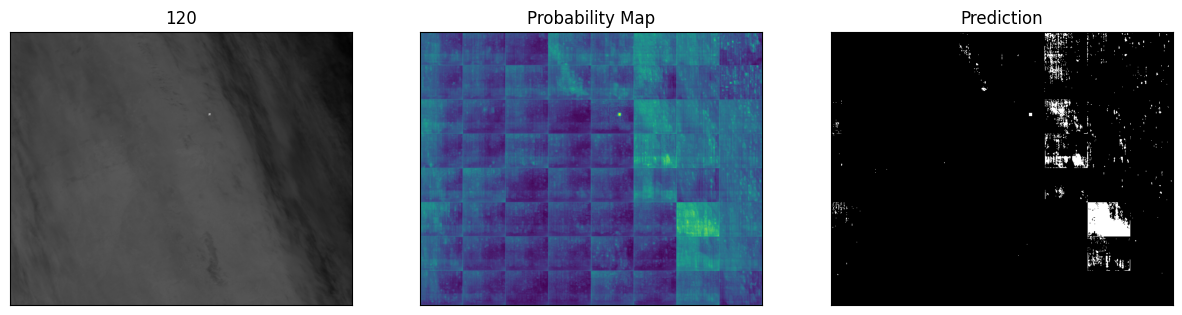

In [ ]:
idx = 120
test_image = test_images[idx]

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.52 seconds


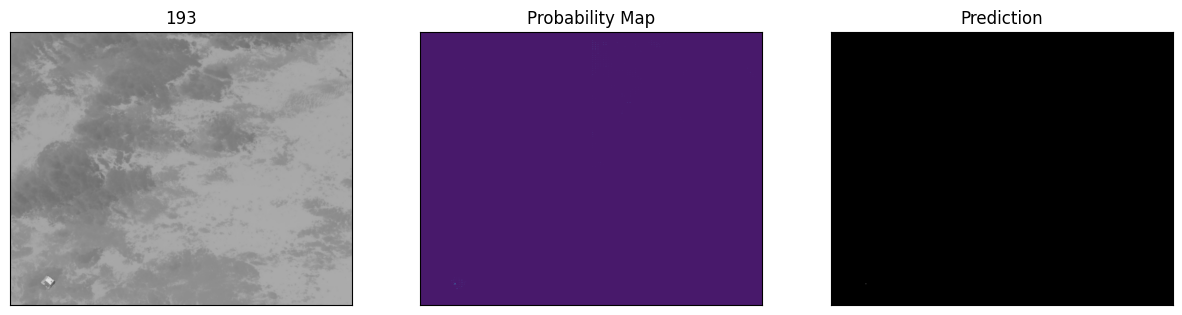

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.09 seconds


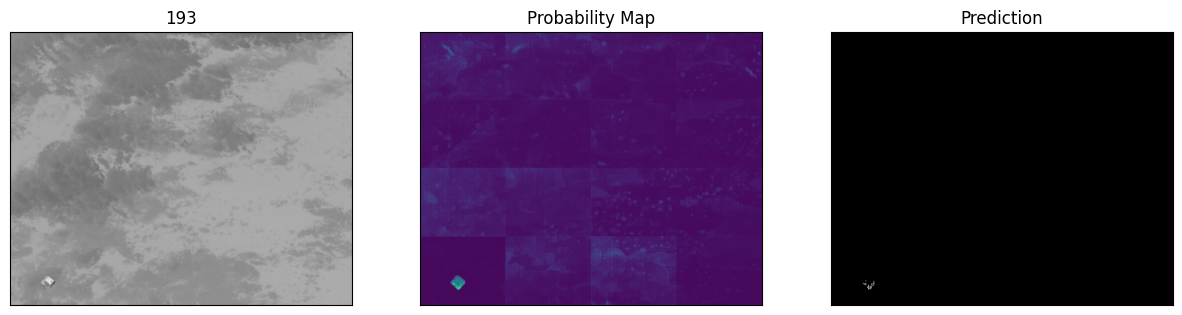

Time taken to prepare image: 0.03 seconds
Time taken to predict: 8.29 seconds


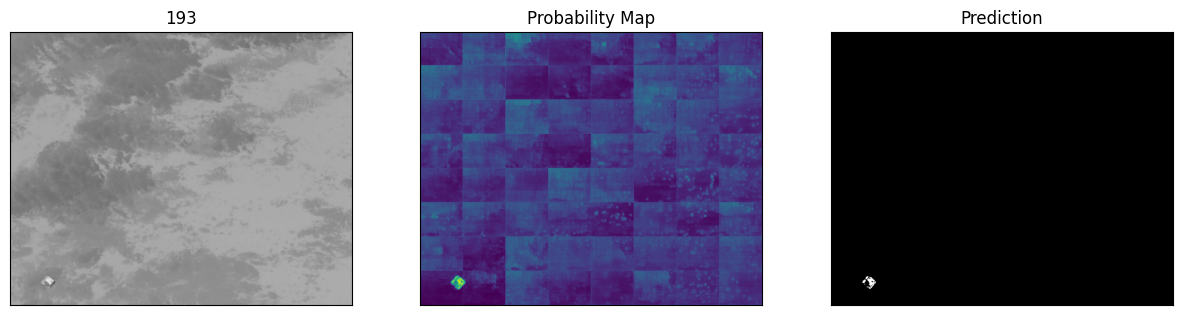

In [ ]:
# idx = random.choice(list(test_images.keys()))
idx = 193
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

In [ ]:
# from torch.utils.data import DataLoader

# test_sam_dataset = SAMDataset(dataset=test_dataset, processor=processor)
# test_dataloader = DataLoader(test_sam_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
# from torch.optim import Adam
# import monai
# from statistics import mean

# model = models[512]
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# model.eval()
# losses = []
# for batch in tqdm(test_dataloader):
#     # forward pass
#     outputs = model(pixel_values=batch["pixel_values"].to(device),
#                     input_boxes=batch["input_boxes"].to(device),
#                     multimask_output=False)

#     # compute loss
#     predicted_masks = outputs.pred_masks.squeeze(1)
#     ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#     loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#     loss.backward()
#     losses.append(loss.item())

In [ ]:
# print(f'Mean DiceCELoss: {mean(losses)}')

In [ ]:
def mask_within_bbox(mask: np.ndarray, bbox: tuple[tuple[int, int], int, int]) -> bool:
    tot_area = np.sum(mask)
    
    (x, y), w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area > 0.5

def joint_intersection(mask1, mask2, thresh) -> bool:
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union) > thresh

In [ ]:
def calc_accuracy(model: SamModel, processor: SamProcessor, images: dict[int, np.ndarray], bboxes: dict[int, tuple], masks, image_size: int, thresh: float = 0.5) -> float:
    device = get_device()
    model.to(device)

    x_factor = original_dims[1] / image_size
    y_factor = original_dims[0] / image_size
    
    accuracies = []
    for idx, image in tqdm(images.items()):
        mask_pred, _ = predict(model, processor, device, image, (image_size, image_size), thresh, verbose=False)
        bbox = bboxes[idx]
        
        if bbox is None:
            if mask_pred.max() == 0:
                accuracies.append(1)
            else:
                accuracies.append(0)
            continue
        
        # (x, y), w, h = bbox
        # bbox = ((round(x/x_factor), round(y/y_factor)), round(w/x_factor), round(h/y_factor))
        
        mask_true = np.array(masks[idx][:, :, 0] / 255, dtype=np.uint8)
        # if mask_within_bbox(mask_pred, bbox):
        if joint_intersection(mask_pred, mask_true, 0.5):
            accuracies.append(1)
        else:
            accuracies.append(0)

    return np.mean(accuracies)

In [ ]:
# test_acc_512 = calc_accuracy(models[512], processors[512], test_images, test_bboxes, 512, thresh=0.65)
# print(test_acc_512)

In [ ]:
# test_acc_1024 = calc_accuracy(models[1024], processors[1024], test_images, test_bboxes, 1024, thresh=0.65)
# print(test_acc_1024)

In [ ]:
# test_acc_2048 = calc_accuracy(models[2048], processors[2048], test_images, test_bboxes, 2048, thresh=0.65)
# print(test_acc_2048)

In [ ]:
def test_threshs(threshs: list[float], model: SamModel, processor: SamProcessor, images: dict[int, np.ndarray], bboxes: dict[int, tuple], masks, image_size: int) -> dict[float, float]:
    accs = {}
    for thresh in threshs:
        print(f"Testing threshold: {thresh}")
        acc = calc_accuracy(model, processor, images, bboxes, masks, image_size, thresh)
        print(f"Accuracy: {acc:.4f}\n")
        accs[thresh] = acc
    return accs

In [ ]:
# thresh_accs_512 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[512], processors[512], val_images, val_bboxes, 512)

# import pickle
# pickle.dump(thresh_accs_512, open("thresh_accs_512_2.pkl", "wb"))

In [ ]:
# thresh_accs_1024 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[1024], processors[1024], val_images, val_bboxes, 1024)

# import pickle
# pickle.dump(thresh_accs_1024, open("thresh_accs_1024_2.pkl", "wb"))

In [ ]:
# thresh_accs_2048 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[2048], processors[2048], val_images, val_bboxes, 2048)

# import pickle
# pickle.dump(thresh_accs_2048, open("thresh_accs_2048_2.pkl", "wb"))